### 1.1) Implementación del algoritmo K-means sin bibliotecas

In [1]:
# Bibliotecas requeridas inicializar datos

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np

from sklearn.cluster import KMeans

[1 0 1 0 0 0 2 2 1 0 0 0 1 0 2 1 2 0 2 2 2 2 2 0 1 1 1 1 2 2 0 1 1 0 2 2 0
 1 1 2 2 1 1 0 0 0 1 1 2 2 2 1 0 1 2 2 1 1 0 1 1 2 2 2 2 1 0 2 1 0 2 0 0 1
 1 0 0 0 2 1 0 0 1 0 1 0 0 0 1 0 1 1 2 2 2 2 0 0 2 2]


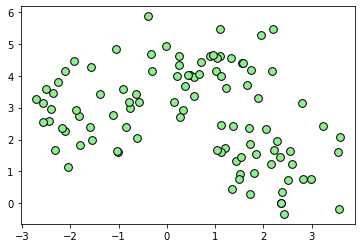

In [6]:
#Generación de los datos

#Cantidad de muestras a generar
num_samples = 100

#Número de clústes a generar
num_clusters = 3

# se crean los datos aleatoriamente
X, y = make_blobs(
   n_samples=num_samples, n_features=2,
   centers=num_clusters, cluster_std=0.8,
   shuffle=True, random_state=0
)

# Se grafican los datos
plt.scatter(
   X[:, 0], X[:, 1],
   c='lightgreen', marker='o',
   edgecolor='black', s=60
)
plt.show()

In [ ]:
# Algorirmo de k means

#Número de clústes a generar
num_clusters = 3



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
import pandas as pd

In [25]:
def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, X_train):
        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs
# Create a dataset of 2D distributions
centers = 3
X_train, true_labels = make_blobs(n_samples=100, centers=centers, random_state=42, n_features=4)
X_train = StandardScaler().fit_transform(X_train)
# Fit centroids to dataset
kmeans = KMeans(n_clusters=centers)
kmeans.fit(X_train)
df = pd.DataFrame(X_train, columns=['1', '2', '3', '4'])

df['Cluster'] = kmeans.evaluate(X_train)[1]
print(df.head())
# View results
"""
class_centers, classification = kmeans.evaluate(X_train)
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue=true_labels,
                style=classification,
                palette="deep",
                legend=None
                )
plt.plot([x for x, _ in kmeans.centroids],
         [y for _, y in kmeans.centroids],
         'k+',
         markersize=10,
         )
plt.show()
"""

          1         2         3         4  Cluster
0 -1.735666 -1.335448 -0.768493  0.590995        0
1  1.246838  0.177534 -0.778308  1.107849        2
2 -1.117502 -1.246104 -0.857135 -0.061859        0
3 -1.091016 -1.279274 -0.499587  0.651497        0
4  1.240921  0.191917 -0.631805  0.914039        2


'\nclass_centers, classification = kmeans.evaluate(X_train)\nsns.scatterplot(x=[X[0] for X in X_train],\n                y=[X[1] for X in X_train],\n                hue=true_labels,\n                style=classification,\n                palette="deep",\n                legend=None\n                )\nplt.plot([x for x, _ in kmeans.centroids],\n         [y for _, y in kmeans.centroids],\n         \'k+\',\n         markersize=10,\n         )\nplt.show()\n'